In [1]:
import numpy as np
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib
import scipy

In [2]:
# Python package for fundamentals of Music processing
import libfmp
import libfmp.c2

In [3]:
Fs = 22050
x, sr = librosa.load('audio/FMP_C3_F03.mp3', sr=Fs, duration=40)

c:\Users\qcirma\Anaconda3\envs\audiocourse\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


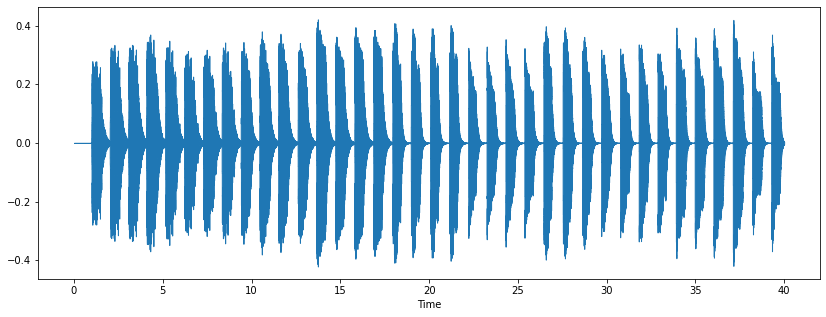

In [4]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

In [5]:
ipd.display(ipd.Audio(x, rate=sr))

In [6]:

# Compute Magnitude STFT
N = 4096
H = 1024
X, T_coef, F_coef = libfmp.c2.stft_convention_fmp(x, Fs, N, H)
Y = np.abs(X) ** 2

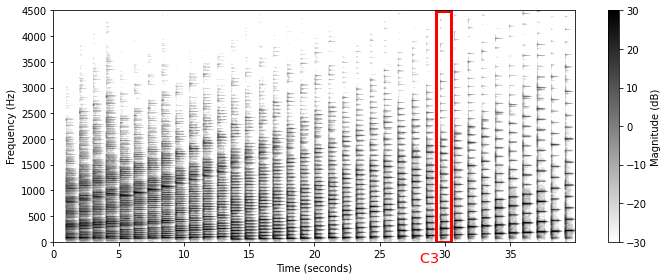

In [8]:
# Plot spectrogram
fig = plt.figure(figsize=(10, 4))
eps = np.finfo(float).eps
plt.imshow(10 * np.log10(eps + Y), origin='lower', aspect='auto', cmap='gray_r', 
           extent=[T_coef[0], T_coef[-1], F_coef[0], F_coef[-1]])
plt.clim([-30, 30])
plt.ylim([0, 4500])
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
cbar = plt.colorbar()
cbar.set_label('Magnitude (dB)')
plt.tight_layout()

# Plot rectangle corresponding to pitch C3 (p=48)
rect = matplotlib.patches.Rectangle((29.3, 0.5), 1.2, 4490, linewidth=3, 
                                    edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)
plt.text(28, -400, r'$\mathrm{C3}$', color='r', fontsize='x-large');

Log Frequency Spectrogram <br> The frequency axis is partitioned logarithmically and labeled linearly according to MIDI pitches

In [9]:
# Computes the center frequency/ies of a MIDI pitch
def f_pitch(p, pitch_ref=69, freq_ref=440.0):
    return 2 ** ((p - pitch_ref) / 12) * freq_ref

# Computes the set of frequency indices that are assigned to a given pitch
def pool_pitch(p, Fs, N, pitch_ref=69, freq_ref=440.0):
    lower = f_pitch(p - 0.5, pitch_ref, freq_ref)
    upper = f_pitch(p + 0.5, pitch_ref, freq_ref)
    k = np.arange(N // 2 + 1)
    k_freq = k * Fs / N  # F_coef(k, Fs, N)
    mask = np.logical_and(lower <= k_freq, k_freq < upper)
    return k[mask]

# Computes a log-frequency spectrogram
def compute_spec_log_freq(Y, Fs, N):
    Y_LF = np.zeros((128, Y.shape[1]))
    for p in range(128):
        k = pool_pitch(p, Fs, N)
        Y_LF[p, :] = Y[k, :].sum(axis=0)
    F_coef_pitch = np.arange(128)
    return Y_LF, F_coef_pitch

In [10]:
Y_LF, F_coef_pitch = compute_spec_log_freq(Y, sr, N)

### Chromagram

In [11]:
def compute_chromagram(Y_LF):
    C = np.zeros((12, Y_LF.shape[1]))
    p = np.arange(128)
    for c in range(12):
        mask = (p % 12) == c
        C[c, :] = Y_LF[mask, :].sum(axis=0)
    return C

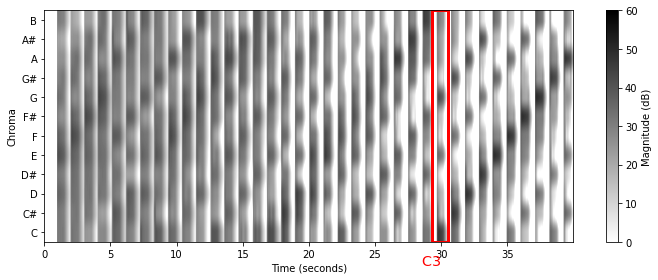

In [12]:
C = compute_chromagram(Y_LF)

fig = plt.figure(figsize=(10, 4))
chroma_label = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
plt.imshow(10 * np.log10(eps + C), origin='lower', aspect='auto', cmap='gray_r', 
           extent=[T_coef[0], T_coef[-1], 0, 12])
plt.clim([0, 60])
plt.xlabel('Time (seconds)')
plt.ylabel('Chroma')
cbar = plt.colorbar()
cbar.set_label('Magnitude (dB)')
plt.yticks(np.arange(12) + 0.5, chroma_label)
plt.tight_layout()

rect = matplotlib.patches.Rectangle((29.3, 0.0), 1.2, 12, linewidth=3, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)
plt.text(28.5, -1.2, r'$\mathrm{C3}$', color='r', fontsize='x-large');

### Energy-based Novelty functions

In [13]:
hop_length = 512
frame_length = 1024
rmse = librosa.feature.rms(x, frame_length=frame_length, hop_length=hop_length).flatten()
rmse_diff = np.zeros_like(rmse)
rmse_diff[1:] = np.diff(rmse)
print(rmse.shape)
print(rmse_diff.shape)

(1723,)
(1723,)


c:\Users\qcirma\Anaconda3\envs\audiocourse\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0027771  -0.00244141
 -0.00219727] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
energy_novelty = np.max([np.zeros_like(rmse_diff), rmse_diff], axis=0)
frames = np.arange(len(rmse))
t = librosa.frames_to_time(frames, sr=sr)

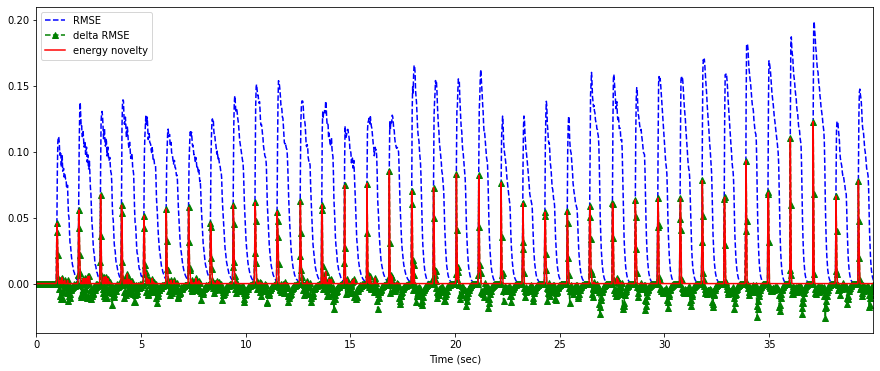

In [15]:
plt.figure(figsize=(15, 6))
plt.plot(t, rmse, 'b--', t, rmse_diff, 'g--^', t, energy_novelty, 'r-')
plt.xlim(0, t.max())
plt.xlabel('Time (sec)')
plt.legend(('RMSE', 'delta RMSE', 'energy novelty')) 

### CQT vs FFT

In [19]:
# CQT Frequencies
cqt_freqs = librosa.core.cqt_frequencies(n_bins=128, fmin=librosa.note_to_hz('C0'), bins_per_octave=12)

# FFT Frequencies
fft_freqs = librosa.fft_frequencies(sr=44100, n_fft=128)

# Notes Center Frequencies
notes_freqs = 440*2**(np.arange(-57, (128-57))/12)

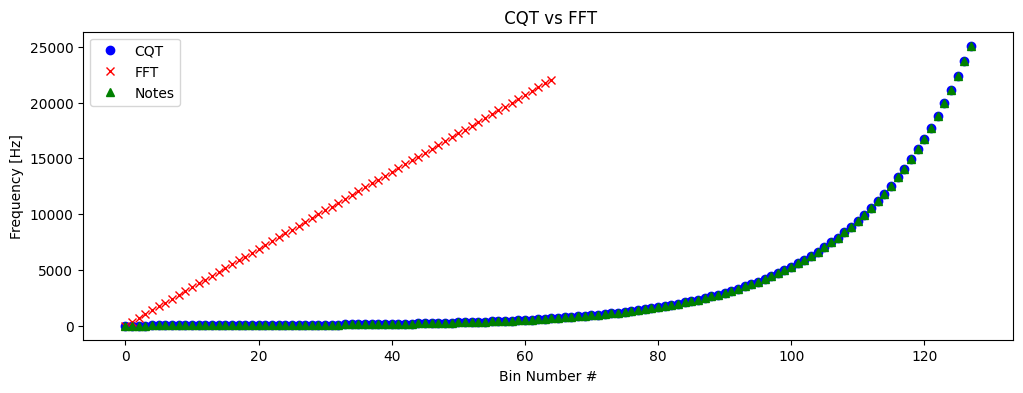

In [8]:
# Plot CQT vs FFT
plt.figure(figsize=(12,4))
plt.plot(cqt_freqs, 'bo', label='CQT')
plt.plot(fft_freqs, 'rx', label= 'FFT')
plt.plot(notes_freqs, 'g^', label = 'Notes')
plt.title(" CQT vs FFT")
plt.xlabel('Bin Number #')
plt.ylabel('Frequency [Hz]')
plt.legend()



In [16]:
# Parameters
## Signal Processing 
fs = 44100                               # Sampling Frequency
nfft = 2048                              # length of the FFT window
overlap = 0.5                            # Hop overlap percentage
hop_length = int(nfft*(1-overlap))       # Number of samples between successive frames
n_bins = 72                              # Number of frequency bins
mag_exp = 4                              # Magnitude Exponent
pre_post_max = 6                         # Pre- and post- samples for peak picking
cqt_threshold = -61                      # Threshold for CQT dB levels, all values below threshold are set to -120 dB

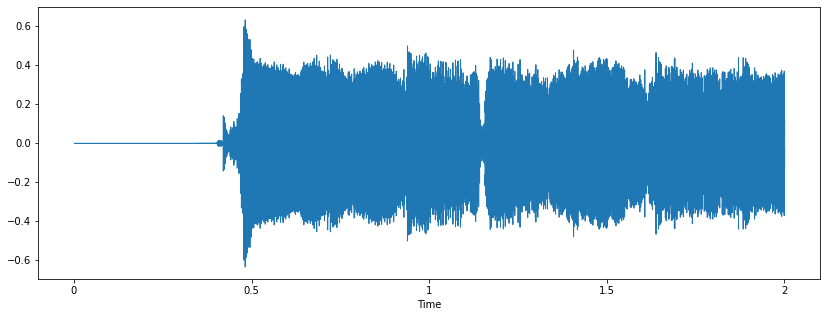

In [20]:
x, sr = librosa.load('audio/guns_N_Roses.wav',sr=fs, mono=True, duration=2)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

(87,)
(87,)


c:\Users\qcirma\Anaconda3\envs\audiocourse\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00875854 -0.04037476
 -0.11373901] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  This is separate from the ipykernel package so we can avoid doing imports until


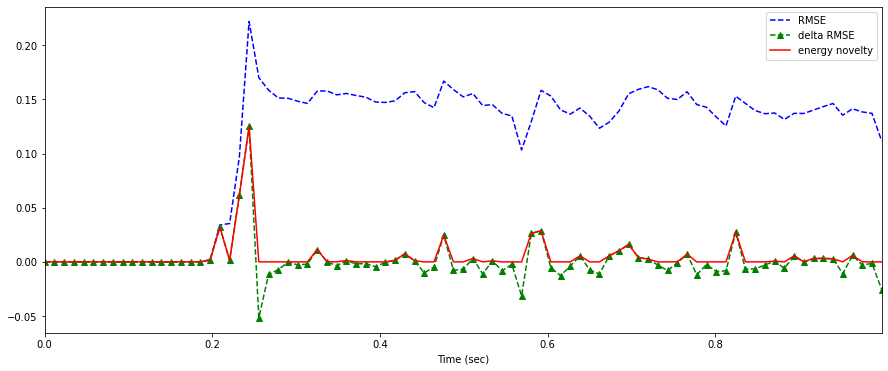

In [21]:
#hop_length = 512
#frame_length = 1024
rmse = librosa.feature.rms(x, frame_length=frame_length, hop_length=hop_length).flatten()
rmse_diff = np.zeros_like(rmse)
rmse_diff[1:] = np.diff(rmse)
print(rmse.shape)
print(rmse_diff.shape)
energy_novelty = np.max([np.zeros_like(rmse_diff), rmse_diff], axis=0)
frames = np.arange(len(rmse))
t = librosa.frames_to_time(frames, sr=sr)
plt.figure(figsize=(15, 6))
plt.plot(t, rmse, 'b--', t, rmse_diff, 'g--^', t, energy_novelty, 'r-')
plt.xlim(0, t.max())
plt.xlabel('Time (sec)')
plt.legend(('RMSE', 'delta RMSE', 'energy novelty')) 

#### DTW

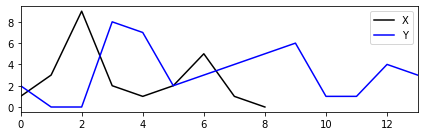

In [126]:
# Two vectors
X =  [1, 3, 9, 2, 1, 2, 5, 1, 0]
Y = [2, 0, 0, 8, 7, 2, 3, 4, 5, 6, 1, 1, 4, 3 ]
N = len(X)
M = len(Y)

plt.figure(figsize=(6, 2))
plt.plot(X, c='k', label='X')
plt.plot(Y, c='b', label='Y')
plt.xlim([0, M-1])
plt.legend()
plt.tight_layout()

In [127]:
# Compute the cost matrix using the Euclidean distance as local cost measure
def compute_cost_matrix(X, Y, metric='euclidean'):
    X, Y = np.atleast_2d(X, Y)
    C = scipy.spatial.distance.cdist(X.T, Y.T, metric=metric)
    return C

C =  compute_cost_matrix(X, Y, metric='euclidean')
print('Cost matrix C =', C, sep='\n')

Cost matrix C =
[[1. 1. 1. 7. 6. 1. 2. 3. 4. 5. 0. 0. 3. 2.]
 [1. 3. 3. 5. 4. 1. 0. 1. 2. 3. 2. 2. 1. 0.]
 [7. 9. 9. 1. 2. 7. 6. 5. 4. 3. 8. 8. 5. 6.]
 [0. 2. 2. 6. 5. 0. 1. 2. 3. 4. 1. 1. 2. 1.]
 [1. 1. 1. 7. 6. 1. 2. 3. 4. 5. 0. 0. 3. 2.]
 [0. 2. 2. 6. 5. 0. 1. 2. 3. 4. 1. 1. 2. 1.]
 [3. 5. 5. 3. 2. 3. 2. 1. 0. 1. 4. 4. 1. 2.]
 [1. 1. 1. 7. 6. 1. 2. 3. 4. 5. 0. 0. 3. 2.]
 [2. 0. 0. 8. 7. 2. 3. 4. 5. 6. 1. 1. 4. 3.]]


In [128]:
# Compute the accumulated cost matrix 
def compute_accumulated_cost_matrix(C):
    N = C.shape[0]
    M = C.shape[1]
    D = np.zeros((N, M))
    D[0, 0] = C[0, 0]
    for n in range(1, N):
        D[n, 0] = D[n-1, 0] + C[n, 0]

    for m in range(1, M):
        D[0, m] = D[0, m-1] + C[0, m]

    for n in range(1, N):
        for m in range(1, M):

            D[n, m] = C[n, m] + min(D[n-1, m], D[n, m-1], D[n-1, m-1])
            
    return D

D =  compute_accumulated_cost_matrix(C)
print('Accumulated cost matrix D =', D, sep='\n')
print('DTW distance DTW(X, Y) =', D[-1, -1])

Accumulated cost matrix D =
[[ 1.  2.  3. 10. 16. 17. 19. 22. 26. 31. 31. 31. 34. 36.]
 [ 2.  4.  5.  8. 12. 13. 13. 14. 16. 19. 21. 23. 24. 24.]
 [ 9. 11. 13.  6.  8. 15. 19. 18. 18. 19. 27. 29. 28. 30.]
 [ 9. 11. 13. 12. 11.  8.  9. 11. 14. 18. 19. 20. 22. 23.]
 [10. 10. 11. 18. 17.  9. 10. 12. 15. 19. 18. 18. 21. 23.]
 [10. 12. 12. 17. 22.  9. 10. 12. 15. 19. 19. 19. 20. 21.]
 [13. 15. 17. 15. 17. 12. 11. 11. 11. 12. 16. 20. 20. 22.]
 [14. 14. 15. 22. 21. 13. 13. 14. 15. 16. 12. 12. 15. 17.]
 [16. 14. 14. 22. 28. 15. 16. 17. 19. 21. 13. 13. 16. 18.]]
DTW distance DTW(X, Y) = 18.0


In [129]:
# Optimal warping path using backtracking
def compute_optimal_warping_path(D):
    N = D.shape[0]
    M = D.shape[1]
    n = N - 1
    m = M - 1
    P = [(n, m)]
    while n > 0 or m > 0:
        if n == 0:
            cell = (0, m - 1)
        elif m == 0:
            cell = (n - 1, 0)
        else:
            val = min(D[n-1, m-1], D[n-1, m], D[n, m-1])
            if val == D[n-1, m-1]:
                cell = (n-1, m-1)
            elif val == D[n-1, m]:
                cell = (n-1, m)
            else:
                cell = (n, m-1)
        P.append(cell)
        (n, m) = cell
    P.reverse()
    return np.array(P)
        
P = compute_optimal_warping_path(D)
print('Optimal warping path P =', P.tolist())

Optimal warping path P = [[0, 0], [0, 1], [1, 2], [2, 3], [2, 4], [3, 5], [4, 5], [5, 6], [6, 7], [6, 8], [6, 9], [7, 10], [7, 11], [7, 12], [8, 13]]


Text(0, 0.5, 'Sequence X')

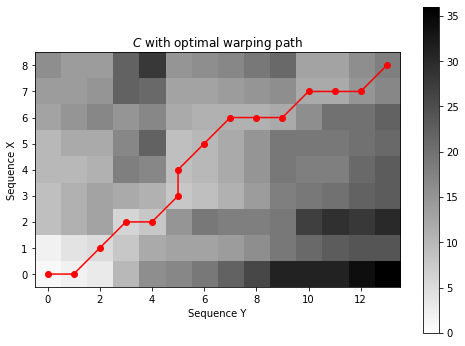

In [130]:

# Accumulated cost matrix with the optimal warping path
P = np.array(P) 
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.imshow(D, cmap='gray_r', origin='lower', aspect='equal')
plt.plot(P[:, 1], P[:, 0], marker='o', color='r')
plt.clim([0, np.max(D)])
plt.colorbar()
plt.title('$C$ with optimal warping path')
plt.xlabel('Sequence Y')
plt.ylabel('Sequence X')

[]

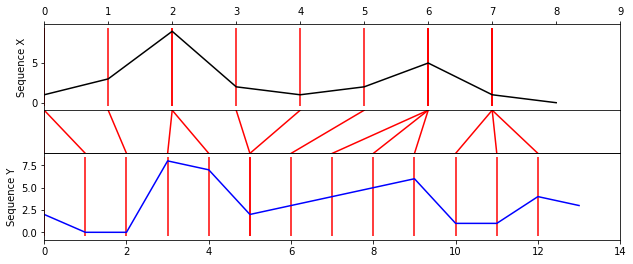

In [131]:
N = len(X)
M = len(Y)

plt.figure(figsize=(8, 3))
ax_X = plt.axes([0, 0.60, 1, 0.40])
plt.plot(X, c='k', label='X')
plt.xlim([0, N])
ax_X.set_ylabel('Sequence X')
ax_X.xaxis.tick_top()
ax_X.xaxis.set_label_position('top') 

ax_Y = plt.axes([0, 0, 1, 0.40])
plt.plot(Y, c='b', label='Y')
plt.xlim([0, M])
ax_Y.set_ylabel('Sequence Y')


step = 1
y_min_X, y_max_X = ax_X.get_ylim()
y_min_Y, y_max_Y = ax_Y.get_ylim()
for t in P[0:-1:step, :]: 
    ax_X.vlines(t[0], y_min_X, y_max_X, color='r')
    ax_Y.vlines(t[1], y_min_Y, y_max_Y, color='r')

ax = plt.axes([0, 0.40, 1, 0.20])
for p in P[0:-1:step, :]: 
    ax.plot((p[0]/N, p[1]/M), (1, -1), color='r')
    ax.set_xlim(0, 1)
    ax.set_ylim(-1, 1)
ax.set_xticks([])
ax.set_yticks([])

